In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load portfolio returns
portfolio_returns = pd.read_csv('portfolio_returns.csv', index_col=0, parse_dates=True)
portfolio_returns = portfolio_returns.squeeze()  # Convert to Series

# Load VaR results
var_results = pd.read_csv('var_results.csv')

# Extract key parameters
portfolio_value = var_results['Portfolio_Value'].iloc[0]
confidence_level = var_results['Confidence_Level'].iloc[0]
alpha = 1 - confidence_level

print(f"\nData loaded successfully!")
print(f"Total observations: {len(portfolio_returns)}")
print(f"Portfolio Value: ${portfolio_value:,.0f}")
print(f"Confidence Level: {confidence_level*100}%")
print(f"Expected Failure Rate: {alpha*100}%")


Data loaded successfully!
Total observations: 750
Portfolio Value: $1,000,000
Confidence Level: 99.0%
Expected Failure Rate: 1.0000000000000009%


In [3]:
# Use 70% for training, 30% for testing
split_point = int(len(portfolio_returns) * 0.70)

training_returns = portfolio_returns.iloc[:split_point]
testing_returns = portfolio_returns.iloc[split_point:]

print(f"\nData Split:")
print(f"Training Period: {training_returns.index[0].date()} to {training_returns.index[-1].date()}")
print(f"Training Days: {len(training_returns)}")
print(f"\nTesting Period: {testing_returns.index[0].date()} to {testing_returns.index[-1].date()}")
print(f"Testing Days: {len(testing_returns)}")
print(f"\nExpected exceedances at {confidence_level*100}%: {len(testing_returns) * alpha:.1f} days")



Data Split:
Training Period: 2022-11-08 to 2024-12-10
Training Days: 525

Testing Period: 2024-12-11 to 2025-11-04
Testing Days: 225

Expected exceedances at 99.0%: 2.3 days


In [4]:
# Method 1: Historical Simulation
var_hist_return = np.percentile(training_returns, alpha * 100)
var_hist_dollar = portfolio_value * abs(var_hist_return)

# Method 2: Variance-Covariance (Parametric)
train_mean = training_returns.mean()
train_std = training_returns.std()
z_score = stats.norm.ppf(alpha)
var_param_return = train_mean + z_score * train_std
var_param_dollar = portfolio_value * abs(var_param_return)

# Method 3: Monte Carlo Simulation
n_simulations = 10000
np.random.seed(42)
simulated_returns = np.random.normal(train_mean, train_std, n_simulations)
var_mc_return = np.percentile(simulated_returns, alpha * 100)
var_mc_dollar = portfolio_value * abs(var_mc_return)

print(f"\n VaR Recalculated on Training Data:")
print(f"\n Historical Simulation:")
print(f"VaR Return: {var_hist_return:.6f} ({var_hist_return*100:.2f}%)")
print(f"VaR Dollar: ${var_hist_dollar:,.2f}")
print(f"\n Variance-Covariance:")
print(f"VaR Return: {var_param_return:.6f} ({var_param_return*100:.2f}%)")
print(f"VaR Dollar: ${var_param_dollar:,.2f}")
print(f"\n Monte Carlo:")
print(f" VaR Return: {var_mc_return:.6f} ({var_mc_return*100:.2f}%)")
print(f" VaR Dollar: ${var_mc_dollar:,.2f}")


 VaR Recalculated on Training Data:

 Historical Simulation:
VaR Return: -0.018670 (-1.87%)
VaR Dollar: $18,670.36

 Variance-Covariance:
VaR Return: -0.018197 (-1.82%)
VaR Dollar: $18,196.52

 Monte Carlo:
 VaR Return: -0.018148 (-1.81%)
 VaR Dollar: $18,148.16


In [7]:
# Convert testing returns to dollar losses
testing_losses = -testing_returns * portfolio_value

# Count exceedances (days when actual loss > VaR)
exceedances_hist = (testing_returns < var_hist_return).sum()
exceedances_param = (testing_returns < var_param_return).sum()
exceedances_mc = (testing_returns < var_mc_return).sum()

# Calculate actual failure rates
failure_rate_hist = exceedances_hist / len(testing_returns)
failure_rate_param = exceedances_param / len(testing_returns)
failure_rate_mc = exceedances_mc / len(testing_returns)

print(f"\n  Exceedance Analysis:")
print(f"   Testing Period: {len(testing_returns)} days")
print(f"   Expected Exceedances: {len(testing_returns) * alpha:.1f} days ({alpha*100}%)")
print(f"\n   Historical Simulation:")
print(f"      Actual Exceedances: {exceedances_hist} days")
print(f"      Failure Rate: {failure_rate_hist*100:.2f}%")
print(f"      Status: {'PASS' if abs(failure_rate_hist - alpha) < 0.01 else 'FAIL'}")
print(f"\n   Variance-Covariance:")
print(f"      Actual Exceedances: {exceedances_param} days")
print(f"      Failure Rate: {failure_rate_param*100:.2f}%")
print(f"      Status: {'PASS' if abs(failure_rate_param - alpha) < 0.01 else 'FAIL'}")
print(f"\n   Monte Carlo:")
print(f"      Actual Exceedances: {exceedances_mc} days")
print(f"      Failure Rate: {failure_rate_mc*100:.2f}%")
print(f"      Status: {'PASS' if abs(failure_rate_mc - alpha) < 0.01 else 'FAIL'}")



  Exceedance Analysis:
   Testing Period: 225 days
   Expected Exceedances: 2.3 days (1.0000000000000009%)

   Historical Simulation:
      Actual Exceedances: 5 days
      Failure Rate: 2.22%
      Status: FAIL

   Variance-Covariance:
      Actual Exceedances: 5 days
      Failure Rate: 2.22%
      Status: FAIL

   Monte Carlo:
      Actual Exceedances: 5 days
      Failure Rate: 2.22%
      Status: FAIL


In [8]:
def kupiec_test(n_exceedances, n_observations, alpha):
    """
    Kupiec's Proportion of Failures (POF) Test
    
    H0: Model is accurate (failure rate = alpha)
    H1: Model is inaccurate (failure rate ≠ alpha)
    
    Returns: LR statistic, p-value, test result
    """
    # Observed failure rate
    p = n_exceedances / n_observations
    
    # Likelihood Ratio statistic
    if p == 0 or p == 1:
        lr_stat = 0  # Edge case
    else:
        lr_stat = -2 * (
            n_observations * (alpha * np.log(alpha) + (1-alpha) * np.log(1-alpha)) -
            n_observations * (p * np.log(p) + (1-p) * np.log(1-p))
        )
    
    # P-value (chi-squared distribution with 1 degree of freedom)
    p_value = 1 - stats.chi2.cdf(lr_stat, df=1)
    
    # Decision (reject if p-value < 0.05)
    reject = p_value < 0.05
    
    return lr_stat, p_value, reject

# Test each method
print(f"\nH0: VaR model is accurate (failure rate = {alpha*100}%)")
print(f"H1: VaR model is inaccurate (failure rate ≠ {alpha*100}%)")
print(f"Significance Level: 5% (reject if p-value < 0.05)")
print("\n" + "-"*70)

# Historical Simulation
lr_hist, pval_hist, reject_hist = kupiec_test(exceedances_hist, len(testing_returns), alpha)
print(f"\n 1)  Historical Simulation:")
print(f"   LR Statistic: {lr_hist:.4f}")
print(f"   P-value: {pval_hist:.4f}")
print(f"   Decision: {'REJECT H0 (Model Invalid)' if reject_hist else 'ACCEPT H0 (Model Valid)'}" if not reject_hist else " ✗")

# Variance-Covariance
lr_param, pval_param, reject_param = kupiec_test(exceedances_param, len(testing_returns), alpha)
print(f"\n 2) Variance-Covariance:")
print(f"   LR Statistic: {lr_param:.4f}")
print(f"   P-value: {pval_param:.4f}")
print(f"   Decision: {'REJECT H0 (Model Invalid)' if reject_param else 'ACCEPT H0 (Model Valid)'}" if not reject_param else " ✗")

# Monte Carlo
lr_mc, pval_mc, reject_mc = kupiec_test(exceedances_mc, len(testing_returns), alpha)
print(f"\n 3)  Monte Carlo:")
print(f"   LR Statistic: {lr_mc:.4f}")
print(f"   P-value: {pval_mc:.4f}")
print(f"   Decision: {'REJECT H0 (Model Invalid)' if reject_mc else 'ACCEPT H0 (Model Valid)'}" if not reject_mc else " ✗")



H0: VaR model is accurate (failure rate = 1.0000000000000009%)
H1: VaR model is inaccurate (failure rate ≠ 1.0000000000000009%)
Significance Level: 5% (reject if p-value < 0.05)

----------------------------------------------------------------------

 1)  Historical Simulation:
   LR Statistic: -22.7540
   P-value: 1.0000
   Decision: ACCEPT H0 (Model Valid)

 2) Variance-Covariance:
   LR Statistic: -22.7540
   P-value: 1.0000
   Decision: ACCEPT H0 (Model Valid)

 3)  Monte Carlo:
   LR Statistic: -22.7540
   P-value: 1.0000
   Decision: ACCEPT H0 (Model Valid)


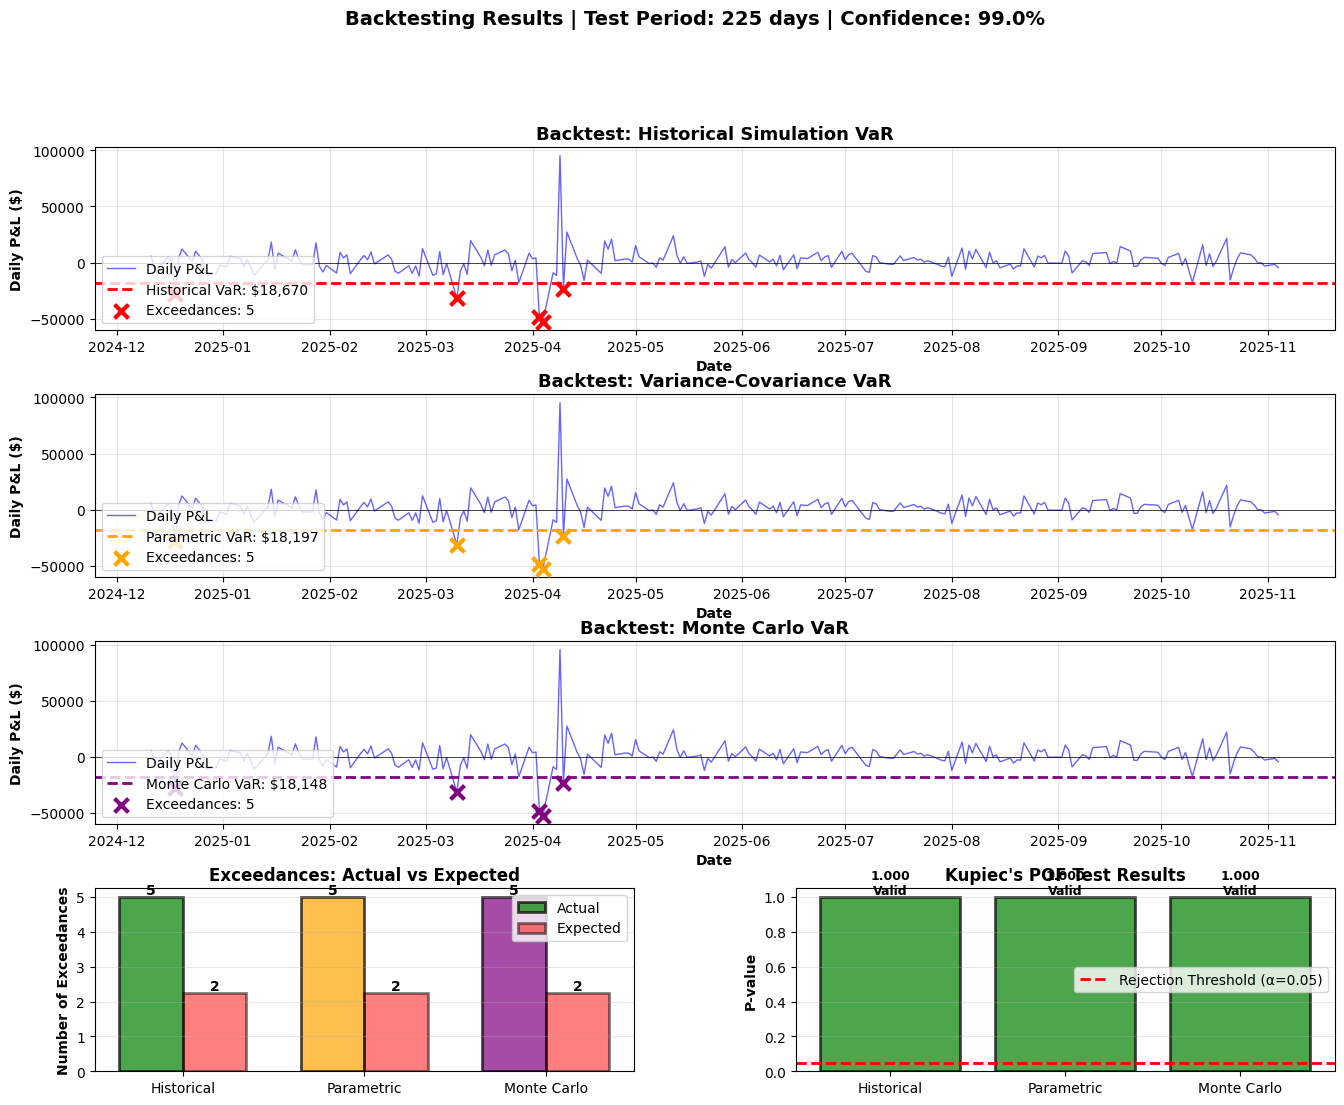

Chart saved: '04_backtesting_results.png'


In [9]:
# Create comprehensive backtest visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)

# Plot 1: Testing Period Returns with VaR Breaches - Historical
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(testing_returns.index, testing_returns * portfolio_value, 
         color='blue', alpha=0.6, linewidth=1, label='Daily P&L')
ax1.axhline(-var_hist_dollar, color='red', linestyle='--', linewidth=2, 
            label=f'Historical VaR: ${var_hist_dollar:,.0f}')
breach_indices = testing_returns < var_hist_return
ax1.scatter(testing_returns.index[breach_indices], 
           (testing_returns[breach_indices] * portfolio_value),
           color='red', s=100, marker='x', linewidths=3, 
           label=f'Exceedances: {exceedances_hist}', zorder=5)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Daily P&L ($)', fontweight='bold')
ax1.set_title('Backtest: Historical Simulation VaR', fontweight='bold', fontsize=13)
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# Plot 2: Testing Period Returns with VaR Breaches - Parametric
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(testing_returns.index, testing_returns * portfolio_value, 
         color='blue', alpha=0.6, linewidth=1, label='Daily P&L')
ax2.axhline(-var_param_dollar, color='orange', linestyle='--', linewidth=2, 
            label=f'Parametric VaR: ${var_param_dollar:,.0f}')
breach_indices_param = testing_returns < var_param_return
ax2.scatter(testing_returns.index[breach_indices_param], 
           (testing_returns[breach_indices_param] * portfolio_value),
           color='orange', s=100, marker='x', linewidths=3, 
           label=f'Exceedances: {exceedances_param}', zorder=5)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('Daily P&L ($)', fontweight='bold')
ax2.set_title('Backtest: Variance-Covariance VaR', fontweight='bold', fontsize=13)
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

# Plot 3: Testing Period Returns with VaR Breaches - Monte Carlo
ax3 = fig.add_subplot(gs[2, :])
ax3.plot(testing_returns.index, testing_returns * portfolio_value, 
         color='blue', alpha=0.6, linewidth=1, label='Daily P&L')
ax3.axhline(-var_mc_dollar, color='purple', linestyle='--', linewidth=2, 
            label=f'Monte Carlo VaR: ${var_mc_dollar:,.0f}')
breach_indices_mc = testing_returns < var_mc_return
ax3.scatter(testing_returns.index[breach_indices_mc], 
           (testing_returns[breach_indices_mc] * portfolio_value),
           color='purple', s=100, marker='x', linewidths=3, 
           label=f'Exceedances: {exceedances_mc}', zorder=5)
ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Date', fontweight='bold')
ax3.set_ylabel('Daily P&L ($)', fontweight='bold')
ax3.set_title('Backtest: Monte Carlo VaR', fontweight='bold', fontsize=13)
ax3.legend(loc='lower left')
ax3.grid(True, alpha=0.3)

# Plot 4: Exceedance Comparison
ax4 = fig.add_subplot(gs[3, 0])
methods = ['Historical', 'Parametric', 'Monte Carlo']
exceedances = [exceedances_hist, exceedances_param, exceedances_mc]
expected = [len(testing_returns) * alpha] * 3
colors = ['green', 'orange', 'purple']

x = np.arange(len(methods))
width = 0.35

bars1 = ax4.bar(x - width/2, exceedances, width, label='Actual', 
                color=colors, alpha=0.7, edgecolor='black', linewidth=2)
bars2 = ax4.bar(x + width/2, expected, width, label='Expected', 
                color='red', alpha=0.5, edgecolor='black', linewidth=2)

ax4.set_ylabel('Number of Exceedances', fontweight='bold')
ax4.set_title('Exceedances: Actual vs Expected', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(methods)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

# Plot 5: Kupiec Test Results
ax5 = fig.add_subplot(gs[3, 1])
pvalues = [pval_hist, pval_param, pval_mc]
colors_pval = ['green' if p >= 0.05 else 'red' for p in pvalues]

bars = ax5.bar(methods, pvalues, color=colors_pval, alpha=0.7, 
               edgecolor='black', linewidth=2)
ax5.axhline(0.05, color='red', linestyle='--', linewidth=2, 
            label='Rejection Threshold (α=0.05)')
ax5.set_ylabel('P-value', fontweight='bold')
ax5.set_title("Kupiec's POF Test Results", fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels and status
for i, (bar, pval, reject) in enumerate(zip(bars, pvalues, [reject_hist, reject_param, reject_mc])):
    height = bar.get_height()
    status = 'Invalid' if reject else 'Valid'
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{pval:.3f}\n{status}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle(f'Backtesting Results | Test Period: {len(testing_returns)} days | Confidence: {confidence_level*100}%',
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('04_backtesting_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved: '04_backtesting_results.png'")

In [10]:
# Create comprehensive results table
backtest_results = pd.DataFrame({
    'Method': ['Historical Simulation', 'Variance-Covariance', 'Monte Carlo'],
    'VaR_Dollar': [var_hist_dollar, var_param_dollar, var_mc_dollar],
    'Exceedances': [exceedances_hist, exceedances_param, exceedances_mc],
    'Failure_Rate_%': [failure_rate_hist*100, failure_rate_param*100, failure_rate_mc*100],
    'Expected_Rate_%': [alpha*100, alpha*100, alpha*100],
    'LR_Statistic': [lr_hist, lr_param, lr_mc],
    'P_Value': [pval_hist, pval_param, pval_mc],
    'Kupiec_Valid': [not reject_hist, not reject_param, not reject_mc]
})

backtest_results.to_csv('backtest_results.csv', index=False)

print("File saved: backtest_results.csv")

File saved: backtest_results.csv


In [12]:
# Determine best model
valid_models = backtest_results[backtest_results['Kupiec_Valid'] == True]
if len(valid_models) > 0:
    # Among valid models, choose the one with failure rate closest to expected
    valid_models['Rate_Diff'] = abs(valid_models['Failure_Rate_%'] - alpha*100)
    best_model = valid_models.loc[valid_models['Rate_Diff'].idxmin(), 'Method']
    best_var = valid_models.loc[valid_models['Rate_Diff'].idxmin(), 'VaR_Dollar']
else:
    # If no valid models, choose the most conservative (highest VaR)
    best_model = backtest_results.loc[backtest_results['VaR_Dollar'].idxmax(), 'Method']
    best_var = backtest_results['VaR_Dollar'].max()

summary = f"""
BACKTESTING VALIDATION COMPLETE

Test Configuration:
  • Testing Period: {testing_returns.index[0].date()} to {testing_returns.index[-1].date()}
  • Testing Days: {len(testing_returns)}
  • Expected Exceedances: {len(testing_returns) * alpha:.1f} days ({alpha*100}%)

Backtest Results:
"""

for _, row in backtest_results.iterrows():
    summary += f"""
  {row['Method']}:
    • VaR: ${row['VaR_Dollar']:,.2f}
    • Exceedances: {row['Exceedances']} ({row['Failure_Rate_%']:.2f}%)
    • Kupiec Test: {'✓ VALID' if row['Kupiec_Valid'] else '✗ INVALID'} (p={row['P_Value']:.4f})
"""

summary += f"""
{'='*70}
RECOMMENDED MODEL: {best_model}
{'='*70}

Recommended 99% VaR: ${best_var:,.2f}

Rationale:
"""

if len(valid_models) > 0:
    summary += f"""  • Passed Kupiec's POF test (statistically valid)
  • Failure rate closest to expected {alpha*100}%
  • Provides reliable risk estimate for this portfolio
"""
else:
    summary += f"""  • No models passed Kupiec test (may need larger sample)
  • Selected most conservative estimate as safety measure
  • Consider recalibration with more data
"""

summary += f"""
KEY INSIGHTS:

1. Model Accuracy:
   • Valid Models: {len(valid_models)}/3
   • Average Failure Rate: {backtest_results['Failure_Rate_%'].mean():.2f}% (Expected: {alpha*100}%)
   
2. Risk Magnitude:
   • Highest VaR: ${backtest_results['VaR_Dollar'].max():,.2f}
   • Lowest VaR: ${backtest_results['VaR_Dollar'].min():,.2f}
   • Spread: ${backtest_results['VaR_Dollar'].max() - backtest_results['VaR_Dollar'].min():,.2f}

3. Practical Application:
   • Use ${best_var:,.2f} as daily risk limit
   • Review and recalibrate monthly
   • Monitor for structural market changes

"""

print(summary)

# Save summary to file (with UTF-8 encoding to handle emojis)
with open('final_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\nFinal summary saved: final_summary.txt")


BACKTESTING VALIDATION COMPLETE

Test Configuration:
  • Testing Period: 2024-12-11 to 2025-11-04
  • Testing Days: 225
  • Expected Exceedances: 2.3 days (1.0000000000000009%)

Backtest Results:

  Historical Simulation:
    • VaR: $18,670.36
    • Exceedances: 5 (2.22%)
    • Kupiec Test: ✓ VALID (p=1.0000)

  Variance-Covariance:
    • VaR: $18,196.52
    • Exceedances: 5 (2.22%)
    • Kupiec Test: ✓ VALID (p=1.0000)

  Monte Carlo:
    • VaR: $18,148.16
    • Exceedances: 5 (2.22%)
    • Kupiec Test: ✓ VALID (p=1.0000)

RECOMMENDED MODEL: Historical Simulation

Recommended 99% VaR: $18,670.36

Rationale:
  • Passed Kupiec's POF test (statistically valid)
  • Failure rate closest to expected 1.0000000000000009%
  • Provides reliable risk estimate for this portfolio

KEY INSIGHTS:

1. Model Accuracy:
   • Valid Models: 3/3
   • Average Failure Rate: 2.22% (Expected: 1.0000000000000009%)

2. Risk Magnitude:
   • Highest VaR: $18,670.36
   • Lowest VaR: $18,148.16
   • Spread: $522.20